In [1]:
import os,sys
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../../LIB/')
from env import ENV

In [2]:
X = pd.read_csv(ENV.application_train_ori.value)
# X = pd.read_pickle(ENV.application_train_cleaned.value)

In [3]:
# X = pd.read_csv(ENV.application_test_ori.value)

In [4]:
print(X.shape)


(307511, 122)


In [5]:
def calculate_na(ser):
    return np.sum(ser.isnull())

def view_hist(ser):
    plt.hist(ser, range=(min(ser.values), max(ser.values)))
    
def scan_nan_portion(df):
    portions = []
    columns = []
    for col in df.columns:
        columns.append(col)
        portions.append(np.sum(df[col].isnull())/len(df))
    return pd.Series(data=portions, index=columns)

In [6]:
p = scan_nan_portion(X)
print(p.describe())

count    122.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64


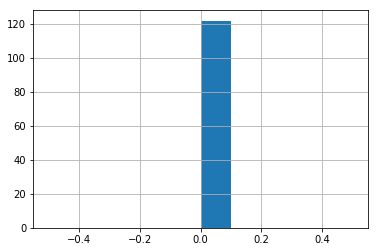

In [7]:
p.hist()

# Preprocessing

### CODE_GENDER

In [8]:
X['CODE_GENDER'].replace('XNA',np.nan, inplace=True)

print(X['CODE_GENDER'].value_counts())
print(calculate_na(X['CODE_GENDER']))

3    202448
2    105059
1         4
Name: CODE_GENDER, dtype: int64
0


### DAYS_LAST_PHONE_CHANGE

In [9]:
print(np.sum(X['DAYS_LAST_PHONE_CHANGE']==0))
X['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)


37672


# Feature_ENgineering

## Solution 3

In [10]:
X['annuity_income_percentage'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
X['car_to_birth_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_BIRTH']
X['car_to_employ_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_EMPLOYED']
X['children_ratio'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']
X['credit_to_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
X['credit_to_goods_ratio'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
X['credit_to_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
X['days_employed_percentage'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
X['income_credit_percentage'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
X['income_per_child'] = X['AMT_INCOME_TOTAL'] / (1 + X['CNT_CHILDREN'])
X['income_per_person'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
X['payment_rate'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
X['phone_to_birth_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_BIRTH']
X['phone_to_employ_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_EMPLOYED']

### why give weight as below

In [11]:
# External sources
X['external_sources_weighted'] = X.EXT_SOURCE_1 * 2 + X.EXT_SOURCE_2 * 3 + X.EXT_SOURCE_3 * 4
for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
    X['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
        X[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [12]:
engineered_numerical_columns = ['annuity_income_percentage',
                                'car_to_birth_ratio',
                                'car_to_employ_ratio',
                                'children_ratio',
                                'credit_to_annuity_ratio',
                                'credit_to_goods_ratio',
                                'credit_to_income_ratio',
                                'days_employed_percentage',
                                'income_credit_percentage',
                                'income_per_child',
                                'income_per_person',
                                'payment_rate',
                                'phone_to_birth_ratio',
                                'phone_to_employ_ratio',
                                'external_sources_weighted',
                                'external_sources_min',
                                'external_sources_max',
                                'external_sources_sum',
                                'external_sources_mean',
                                'external_sources_nanmedian']

# Aggregation features

In [13]:
AGGREGATION_RECIPIES = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('OWN_CAR_AGE', 'max'),
                                              ('OWN_CAR_AGE', 'sum')]),
    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_INCOME_TOTAL', 'mean'),
                                            ('DAYS_REGISTRATION', 'mean'),
                                            ('EXT_SOURCE_1', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                 ('CNT_CHILDREN', 'mean'),
                                                 ('DAYS_ID_PUBLISH', 'mean')]),
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                           ('EXT_SOURCE_2', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                  ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                  ('APARTMENTS_AVG', 'mean'),
                                                  ('BASEMENTAREA_AVG', 'mean'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('EXT_SOURCE_3', 'mean'),
                                                  ('NONLIVINGAREA_AVG', 'mean'),
                                                  ('OWN_CAR_AGE', 'mean'),
                                                  ('YEARS_BUILD_AVG', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                            ('EXT_SOURCE_1', 'mean')]),
    (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                           ('CNT_CHILDREN', 'mean'),
                           ('CNT_FAM_MEMBERS', 'mean'),
                           ('DAYS_BIRTH', 'mean'),
                           ('DAYS_EMPLOYED', 'mean'),
                           ('DAYS_ID_PUBLISH', 'mean'),
                           ('DAYS_REGISTRATION', 'mean'),
                           ('EXT_SOURCE_1', 'mean'),
                           ('EXT_SOURCE_2', 'mean'),
                           ('EXT_SOURCE_3', 'mean')]),
]

In [14]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = X.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        X = X.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)
        

# Solution 4

### Hand Crafted features

###### diff features

In [15]:
diff_feature_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    for select, agg in tqdm(specs):
        if agg in ['mean','median','max','min']:
            groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            diff_name = '{}_diff'.format(groupby_aggregate_name)
            abs_diff_name = '{}_abs_diff'.format(groupby_aggregate_name)

            X[diff_name] = X[select] - X[groupby_aggregate_name] 
            X[abs_diff_name] = np.abs(X[select] - X[groupby_aggregate_name]) 

            diff_feature_names.append(diff_name)
            diff_feature_names.append(abs_diff_name)

###### Employment

In [16]:
X['DAYS_EMPLOYED'].replace(365243,np.nan, inplace=True)
X['long_employment'] = (X['DAYS_EMPLOYED'] < -2000).astype(int)


In [17]:
X['retirement_age'] = (X['DAYS_BIRTH'] < -14000).astype(int)


# Solution 5

## Hand Crafted

In [18]:
X['cnt_non_child'] = X['CNT_FAM_MEMBERS'] - X['CNT_CHILDREN']
X['child_to_non_child_ratio'] = X['CNT_CHILDREN'] / X['cnt_non_child']
X['income_per_non_child'] = X['AMT_INCOME_TOTAL'] / X['cnt_non_child']
X['credit_per_person'] = X['AMT_CREDIT'] / X['CNT_FAM_MEMBERS']
X['credit_per_child'] = X['AMT_CREDIT'] / (1 + X['CNT_CHILDREN'])
X['credit_per_non_child'] = X['AMT_CREDIT'] / X['cnt_non_child']

In [19]:
p = scan_nan_portion(X)
print(p.describe())

count    259.000000
mean       0.002114
std        0.017196
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.180072
dtype: float64


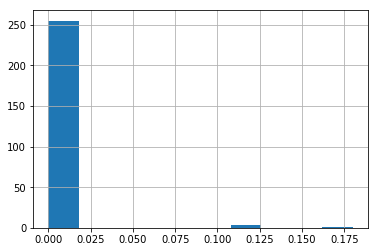

In [20]:
p.hist()

# Saving

In [21]:
import pickle

In [22]:
p = scan_nan_portion(X)
print(p.describe())

count    259.000000
mean       0.002114
std        0.017196
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.180072
dtype: float64


In [23]:
X.shape

(307511, 259)

In [24]:
pickle.dump(X,open(ENV.application_train_reproduce.value,'wb'))

In [25]:
len(X.SK_ID_CURR.unique())

307511